# Neural Networks Tunning

## Content
* Droput
* Weights initialization
    * Default method
    * He method
    * Xavier method
* Gradient Descent
* Batch Normalization

Required tools

In [3]:
import numpy as np
import pandas as pd
import torch
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

Required config

In [2]:
torch.manual_seed(0)

## Introduction
The following methods serve the following purposes:
* Help the optimizer convergence
* Prevent overfitting
* Increase accuracy

## Dropout
This method improves the performance of deep neural networks in the sense of preventing overfitting. 
  
If we use too many layers or too many neurons, we risk overfitting.
If our model is overly simplified, we risk underfitting. We could try different combinations of the number of neurons and layers,
but it will take too much time and resources. A solution is to start with a model that is complex, and apply this form of regularization. Dropout is a popular regularization technique use exclusively for neural networks.
  
Dropout involve two phases: 
1. The training phase is where we implement the dropout method.
2. The evaluation phase, where we turn off the drop out method to test the performance of our model.
  
The dropout is implemented by multiplying the activation function with the Bernoulli random variable. The Bernoulli distribution is a discrete probability distribution where the random variable $B\sim Ber(p)$ takes on the value 0 with probability $p$, and takes on the value 1 with the probability $1 - p$. 

So, for the $i$-th hidden layer with $k$ neurons consider the following independent eeuqly distributed random variables $B_{l,1},...,B_{l,k} \sim Ber(p_i)$ for a fixed $0<p_i<1$. We'll multiply the $j$-th neueron with the realization of it's respective $j$-th random variable. If the realization of such random variable gets to be 0, we'll be shutting off it's corresponding neuron. We'll follow this process for each neuron in every hidden layer in the forward step while training. Consider that that the random variables are independet not only across neurons, but acoross layers. Moreover, acoross iterations, so the process is repeated for each iteration of training.
  
The larger $p$ the more neurons we remove, thus preventing overfitting. 
* If $p=0$, then none of the nerons gets removed.
* If $p=0.25$, then we expect a very little amount of neurons to be removed.
* If $0 = 0.5$, then we expect half of the nerond to be removed.
* If $p=0.75$, then we expect a very large amount of neurons to be removed. 
* If $p=0$, then all the neurons gets removed. 
Generally the more neurons the larger value of $p$ should be used.
* For the layers with less neurons we use values for $p$ between 0.1 and 0.05 * For the layers with more neurons we use a value for $p$ of 0.5.
  
For the evaluation we do not multiply the neueron with its Bernoulli random variable. We simply run the neural network with all the neurons being active.

In order to apply dropout to a neural network with $l$ hidden layers $n_1,n_2,...,n_l$ and probability values $p_1,p_2,...,p_l$ use the following code:

**nn**  
`class Net(nn.Module):`  
`    def __init__(self, layers, dropout_probs):`  
`        super(Net, self).__init__()`  
`        self.hidden = nn.ModuleList()`  
`        self.dropout_probs = dropout_probs`  
` `  
`        for i, (input_size, output_size) in enumerate(zip(layers, layers[1:])):`  
`            self.hidden.append(nn.Linear(input_size, output_size))`  
`            if i < len(dropout_probs):`  
`                self.hidden.append(nn.Dropout(p=dropout_probs[i]))`  
`  `  
`    def forward(self, activation):`  
`        L = len(self.hidden)`  
`        dropout_indices = range(1, L, 2)`  
` `  
`        for i, layer in enumerate(self.hidden):`  
`            if i not in dropout_indices:`  
`                activation = torch.relu(layer(activation))`  
`            else:`  
`                activation = layer(activation)`  
`        return activation`  
` `  
`layers = [input_size, n_1, n_2, ..., n_l, output_size]`  
`dropout_probs = [p_1, ..., p_l]`  
`model = Net(layers = layers, dropout_probs = dropout_probs)`  


**sequential**  
`model = nn.Sequential(`  
`    nn.Linear(input_size, n_1),`  
`    nn.ReLU(),`  
`    nn.Dropout(p_1),`  
`    nn.Linear(n_1, n_2),`  
`    nn.ReLU(),`  
`    nn.Dropout(p_2),`  
`    .`  
`    .`  
`    .`  
`    nn.Linear(n_{l-1}, n_l),`  
`    nn.ReLU(),`  
`    nn.Dropout(p_l),`  
`    nn.Linear(n_l, output_size)`    



Do not forget, for a model `model`, previous to training, to use the following code:  
`model.train()`

Also, previous to evaluation, to use the following code:  
`model.eval`

Example for classification

In [2]:
## -1. Auxiliary functions

# The function for plotting the diagram
from matplotlib.colors import ListedColormap
def plot_decision_regions_3class(data_set, model=None):
    cmap_light = ListedColormap([ '#0000FF','#FF0000'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#00AAFF'])
    X = data_set.x.numpy()
    y = data_set.y.numpy()
    h = .02
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1 
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1 
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
    newdata = np.c_[xx.ravel(), yy.ravel()]
    
    Z = data_set.multi_dim_poly(newdata).flatten()
    f = np.zeros(Z.shape)
    f[Z > 0] = 1
    f = f.reshape(xx.shape)
    if model != None:
        model.eval()
        XX = torch.Tensor(newdata)
        _, yhat = torch.max(model(XX), 1)
        yhat = yhat.numpy().reshape(xx.shape)
        plt.pcolormesh(xx, yy, yhat, cmap=cmap_light)
        plt.contour(xx, yy, f, cmap=plt.cm.Paired)
    else:
        plt.contour(xx, yy, f, cmap=plt.cm.Paired)
        plt.pcolormesh(xx, yy, f, cmap=cmap_light) 

    plt.title("decision region vs True decision boundary")

# The function for calculating accuracy
def accuracy(model, data_set):
    _, yhat = torch.max(model(data_set.x), 1)
    return (yhat == data_set.y).numpy().mean()

In [9]:
## 0. Get required tools
from torch import nn,optim
from torch.utils.data import Dataset

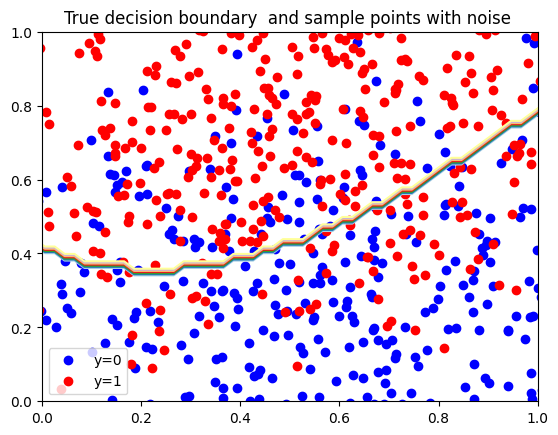

In [10]:
## 1. Create Dataset object

# Create data class for creating dataset object
class Data(Dataset):
    
    # Constructor
    def __init__(self, N_SAMPLES=1000, noise_std=0.15, train=True):
        a = np.matrix([-1, 1, 2, 1, 1, -3, 1]).T
        self.x = np.matrix(np.random.rand(N_SAMPLES, 2))
        self.f = np.array(a[0] + (self.x) * a[1:3] + np.multiply(self.x[:, 0], self.x[:, 1]) * a[4] + np.multiply(self.x, self.x) * a[5:7]).flatten()
        self.a = a
       
        self.y = np.zeros(N_SAMPLES)
        self.y[self.f > 0] = 1
        self.y = torch.from_numpy(self.y).type(torch.LongTensor)
        self.x = torch.from_numpy(self.x).type(torch.FloatTensor)
        self.x = self.x + noise_std * torch.randn(self.x.size())
        self.f = torch.from_numpy(self.f)
        self.a = a
        if train == True:
            torch.manual_seed(1)
            self.x = self.x + noise_std * torch.randn(self.x.size())
            torch.manual_seed(0)
        
    # Getter        
    def __getitem__(self, index):    
        return self.x[index], self.y[index]
    
    # Get Length
    def __len__(self):
        return self.len
    
    # Plot the diagram
    def plot(self):
        X = data_set.x.numpy()
        y = data_set.y.numpy()
        h = .02
        x_min, x_max = X[:, 0].min(), X[:, 0].max()
        y_min, y_max = X[:, 1].min(), X[:, 1].max() 
        xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))
        Z = data_set.multi_dim_poly(np.c_[xx.ravel(), yy.ravel()]).flatten()
        f = np.zeros(Z.shape)
        f[Z > 0] = 1
        f = f.reshape(xx.shape)
        
        plt.title('True decision boundary  and sample points with noise ')
        plt.plot(self.x[self.y == 0, 0].numpy(), self.x[self.y == 0,1].numpy(), 'bo', label='y=0') 
        plt.plot(self.x[self.y == 1, 0].numpy(), self.x[self.y == 1,1].numpy(), 'ro', label='y=1')
        plt.contour(xx, yy, f,cmap=plt.cm.Paired)
        plt.xlim(0,1)
        plt.ylim(0,1)
        plt.legend()
    
    # Make a multidimension ploynomial function
    def multi_dim_poly(self, x):
        x = np.matrix(x)
        out = np.array(self.a[0] + (x) * self.a[1:3] + np.multiply(x[:, 0], x[:, 1]) * self.a[4] + np.multiply(x, x) * self.a[5:7])
        out = np.array(out)
        return out

# Create a dataset object
data_set = Data(noise_std=0.2)
data_set.plot()

# Create another dataset object for validation
validation_set = Data(train = False)

In [11]:
## 2. Create a model class

# Neural network with one hidden layer and droput
class Net(nn.Module):
    
    # Constructor
    def __init__(self, in_size, n_hidden, out_size, p = 0):
        super(Net, self).__init__()
        self.drop = nn.Dropout(p = p)
        self.linear1 = nn.Linear(in_size, n_hidden)
        self.linear2 = nn.Linear(n_hidden, n_hidden)
        self.linear3 = nn.Linear(n_hidden, out_size)
    
    # Prediction function
    def forward(self, x):
        x = torch.relu(self.drop(self.linear1(x)))
        x = torch.relu(self.drop(self.linear2(x)))
        x = self.linear3(x)
        return x

# Model object with no dropout
model = Net(2, 300, 2)
print(model)

# Model object with droput
model_drop = Net(2, 300, 2, p = 0.5)
print(model_drop)

Net(
  (drop): Dropout(p=0, inplace=False)
  (linear1): Linear(in_features=2, out_features=300, bias=True)
  (linear2): Linear(in_features=300, out_features=300, bias=True)
  (linear3): Linear(in_features=300, out_features=2, bias=True)
)
Net(
  (drop): Dropout(p=0.5, inplace=False)
  (linear1): Linear(in_features=2, out_features=300, bias=True)
  (linear2): Linear(in_features=300, out_features=300, bias=True)
  (linear3): Linear(in_features=300, out_features=2, bias=True)
)


In [12]:
## 3. Trainer function (works just for this case)

# Initialice loss dictionaries
LOSS = {}
LOSS['training data no dropout'] = []
LOSS['validation data no dropout'] = []
LOSS['training data dropout'] = []
LOSS['validation data dropout'] = []

# Trainer function
def train_model(epochs):
    
    for epoch in range(epochs):
        # All the samples are used for training 
        yhat = model(data_set.x)
        yhat_drop = model_drop(data_set.x)
        loss = criterion(yhat, data_set.y)
        loss_drop = criterion(yhat_drop, data_set.y)

        # Store the loss for both the training and validation data for both models 
        LOSS['training data no dropout'].append(loss.item())
        LOSS['validation data no dropout'].append(criterion(model(validation_set.x), validation_set.y).item())
        LOSS['training data dropout'].append(loss_drop.item())
        model_drop.eval()
        LOSS['validation data dropout'].append(criterion(model_drop(validation_set.x), validation_set.y).item())
        model_drop.train()

        optimizer_ofit.zero_grad()
        optimizer_drop.zero_grad()
        loss.backward()
        loss_drop.backward()
        optimizer_ofit.step()
        optimizer_drop.step()

In [13]:
## 4. Create objects required fot training 

# Criterion function
criterion = torch.nn.CrossEntropyLoss()

# Optimizers
optimizer_ofit = torch.optim.Adam(model.parameters(), lr = 0.01)
optimizer_drop = torch.optim.Adam(model_drop.parameters(), lr = 0.01)

In [14]:
## 5. Train model

# Set the model to training mode
model_drop.train()

# Train model
train_model(epochs = 500)

# Set the model to evaluation model
model_drop.eval()

Net(
  (drop): Dropout(p=0.5, inplace=False)
  (linear1): Linear(in_features=2, out_features=300, bias=True)
  (linear2): Linear(in_features=300, out_features=300, bias=True)
  (linear3): Linear(in_features=300, out_features=2, bias=True)
)

In [15]:
# Print out the accuracy of the model without dropout
print("The accuracy of the model without dropout: ", accuracy(model, validation_set))
# Print out the accuracy of the model with dropout
print("The accuracy of the model with dropout: ", accuracy(model_drop, validation_set))

The accuracy of the model without dropout:  0.814
The accuracy of the model with dropout:  0.847


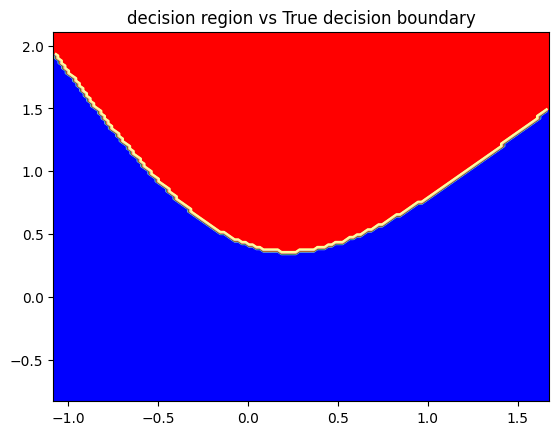

In [16]:
# Plot the decision boundary 
plot_decision_regions_3class(data_set)

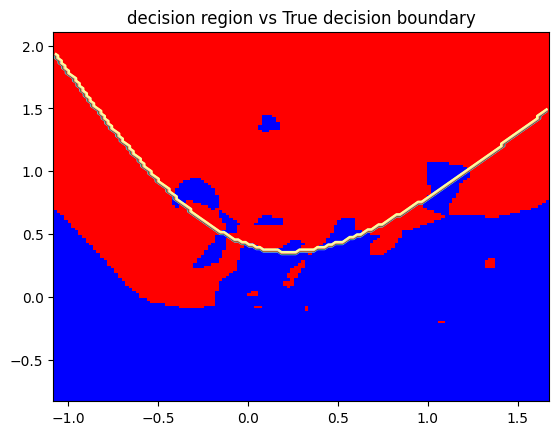

In [17]:
# The model without dropout
plot_decision_regions_3class(data_set, model)

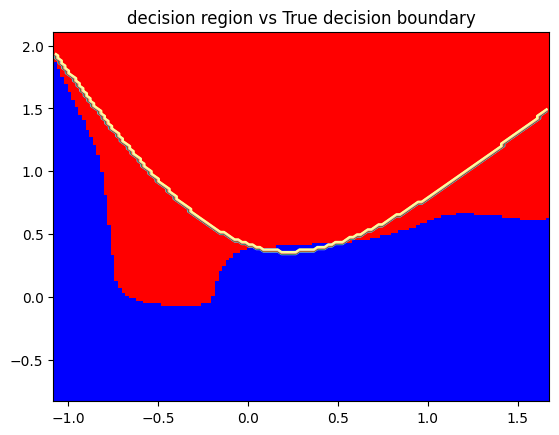

In [18]:
# The model with dropout
plot_decision_regions_3class(data_set, model_drop)

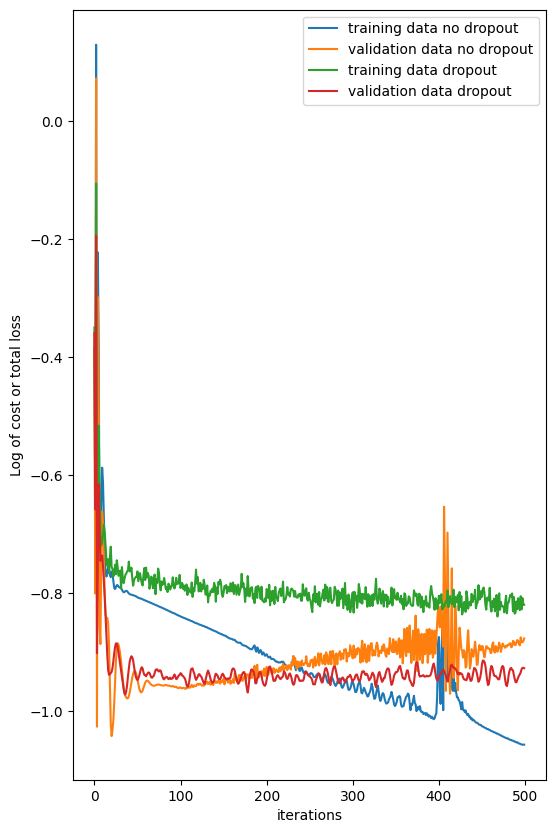

In [19]:
# Plot the LOSS
plt.figure(figsize=(6.1, 10))
def plot_LOSS():
    for key, value in LOSS.items():
        plt.plot(np.log(np.array(value)), label=key)
        plt.legend()
        plt.xlabel("iterations")
        plt.ylabel("Log of cost or total loss")

plot_LOSS()

Example for regression

In [4]:
## 0. Get requiered tools
from torch import nn,optim
from torch.utils.data import Dataset

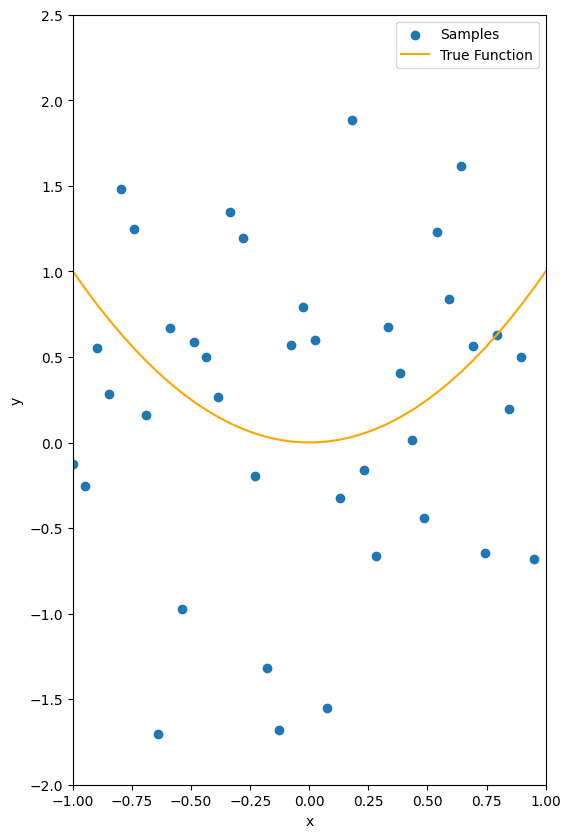

In [5]:
## 1. Load data into a Dataset object

# Create Dataset class
class Data(Dataset):
    
    # Constructor
    def __init__(self, N_SAMPLES=40, noise_std=1, train=True):
        self.x = torch.linspace(-1, 1, N_SAMPLES).view(-1, 1)
        self.f = self.x ** 2
        if train != True:
            torch.manual_seed(1)
            self.y = self.f + noise_std * torch.randn(self.f.size())
            self.y = self.y.view(-1, 1)
            torch.manual_seed(0)
        else:
            self.y = self.f + noise_std * torch.randn(self.f.size())
            self.y = self.y.view(-1, 1)
            
    # Getter
    def __getitem__(self, index):    
        return self.x[index], self.y[index]
    
    # Get Length
    def __len__(self):
        return self.len
    
    # Plot the data
    def plot(self):
        plt.figure(figsize = (6.1, 10))
        plt.scatter(self.x.numpy(), self.y.numpy(), label="Samples")
        plt.plot(self.x.numpy(), self.f.numpy() ,label="True Function", color='orange')
        plt.xlabel("x")
        plt.ylabel("y")
        plt.xlim((-1, 1))
        plt.ylim((-2, 2.5))
        plt.legend(loc="best")
        plt.show()

# Create Dataset object
data_set = Data()
data_set.plot()

# Create another Dataset object for validation
validation_set = Data(train = False)

In [6]:
## 2. Create model 

# Create the class for model
class Net(nn.Module):
    
    # Constructor
    def __init__(self, in_size, n_hidden, out_size, p=0):
        super(Net, self).__init__()
        self.drop = nn.Dropout(p=p)
        self.linear1 = nn.Linear(in_size, n_hidden)
        self.linear2 = nn.Linear(n_hidden, n_hidden)
        self.linear3 = nn.Linear(n_hidden, out_size)
        
    def forward(self, x):
        x = torch.relu(self.drop(self.linear1(x)))
        x = torch.relu(self.drop(self.linear2(x)))
        x = self.linear3(x)
        return x

# Create a model object with no dropout
model = Net(1, 300, 1)
print(model)
# Create model object with dropout
model_drop = Net(1, 300, 1, p=0.5)
print(model_drop)

Net(
  (drop): Dropout(p=0, inplace=False)
  (linear1): Linear(in_features=1, out_features=300, bias=True)
  (linear2): Linear(in_features=300, out_features=300, bias=True)
  (linear3): Linear(in_features=300, out_features=1, bias=True)
)
Net(
  (drop): Dropout(p=0.5, inplace=False)
  (linear1): Linear(in_features=1, out_features=300, bias=True)
  (linear2): Linear(in_features=300, out_features=300, bias=True)
  (linear3): Linear(in_features=300, out_features=1, bias=True)
)


In [7]:
## 3. Create training function

# Initialice loss dictionaries
LOSS = {}
LOSS['training data no dropout'] = []
LOSS['validation data no dropout'] = []
LOSS['training data dropout'] = []
LOSS['validation data dropout'] = []

# Trainer function
def train_model(epochs):
    for epoch in range(epochs):
        yhat = model(data_set.x)
        yhat_drop = model_drop(data_set.x)
        loss = criterion(yhat, data_set.y)
        loss_drop = criterion(yhat_drop, data_set.y)

        #store the loss for  both the training and validation  data for both models 
        LOSS['training data no dropout'].append(loss.item())
        LOSS['validation data no dropout'].append(criterion(model(validation_set.x), validation_set.y).item())
        LOSS['training data dropout'].append(loss_drop.item())
        model_drop.eval()
        LOSS['validation data dropout'].append(criterion(model_drop(validation_set.x), validation_set.y).item())
        model_drop.train()

        optimizer_ofit.zero_grad()
        optimizer_drop.zero_grad()
        loss.backward()
        loss_drop.backward()
        optimizer_ofit.step()
        optimizer_drop.step()

In [8]:
## 4. Create objects for traning

# Create criterion function
criterion = torch.nn.MSELoss()

# Create optimizer objects
optimizer_ofit = torch.optim.Adam(model.parameters(), lr=0.01)
optimizer_drop = torch.optim.Adam(model_drop.parameters(), lr=0.01)

In [9]:
## 5. Train the model

# Set the model to training  mode
model_drop.train()

# Train model
train_model(epochs = 500)

# Set the model to evaluation mode
model_drop.eval()

Net(
  (drop): Dropout(p=0.5, inplace=False)
  (linear1): Linear(in_features=1, out_features=300, bias=True)
  (linear2): Linear(in_features=300, out_features=300, bias=True)
  (linear3): Linear(in_features=300, out_features=1, bias=True)
)

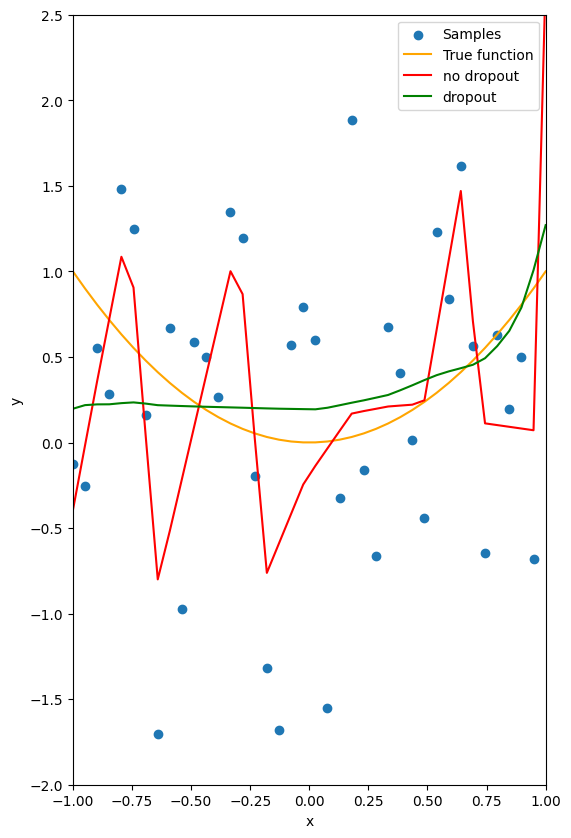

In [10]:
## 6.  Make the prediction

# Compute predictions
yhat = model(data_set.x)
yhat_drop = model_drop(data_set.x)

# Plot predictions
plt.figure(figsize=(6.1, 10))

plt.scatter(data_set.x.numpy(), data_set.y.numpy(), label="Samples")
plt.plot(data_set.x.numpy(), data_set.f.numpy(), label="True function", color='orange')
plt.plot(data_set.x.numpy(), yhat.detach().numpy(), label='no dropout', c='r')
plt.plot(data_set.x.numpy(), yhat_drop.detach().numpy(), label="dropout", c ='g')

plt.xlabel("x")
plt.ylabel("y")
plt.xlim((-1, 1))
plt.ylim((-2, 2.5))
plt.legend(loc = "best")
plt.show()

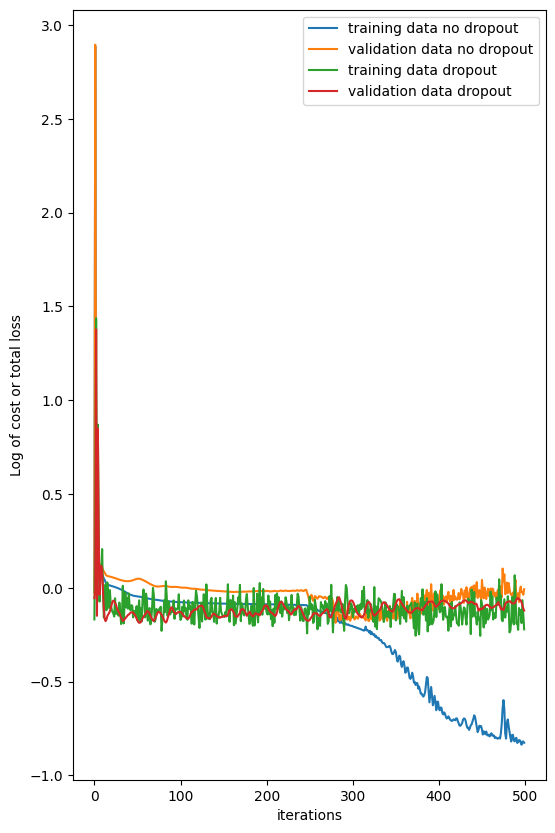

In [12]:
# Plot the loss
plt.figure(figsize=(6.1, 10))
for key, value in LOSS.items():
    plt.plot(np.log(np.array(value)), label=key)
    plt.legend()
    plt.xlabel("iterations")
    plt.ylabel("Log of cost or total loss")

## Initialization Weights

Many times when a neural network is not functioning, it has to do with the fact that the weights were not initialized correctly during the training phase of the neural network.

For example, if the weights of one neural network layer are equally initialized, the linear weights for the first layer for each neuron are the same. This is because each neuron will have the same output and such have the same gradian update. Thus, the model will do a horrible job of predicting the decision function. As a result it is recommended that we randomly initialize our parameters.

We may initialize our parameters by sampling from the uniform distribution, this distribution has a constant probability in a specified range. The problem is that the values that we sample is squashed between -0.05 and 0.05 which is too close together and defeats the idea of randomly sampling the values of the weights. But there is also a problem with making the range of our distribution, too wide. If we draw samples near the tails of the distribution, the values will be large, this can lead to vanishinig gradient. 
  
## Default method  
This one is used for any activation function. Supose we have a net with $L_{in}$ neurons for a layer. The default inicilization is to initialice the parameters by randomly selecting them from a uniform distribution with range $(-\frac{1}{\sqrt{L_{in}}}, \frac{1}{\sqrt{L_{in}}})$. 
  
There is no need for coding as the initialization gets automatically donde when instanciating a model object.
  
## Xavier method  
This one is used for the $tanh$ function. Supose we have a net with $L_{in}$ neurons and $L_{out}$ neurons for a layer. The Xavier method is to initialize the parameters by randomly selecting them from a uniform distribution with range $(-\frac{6}{\sqrt{L_{in} + L_{out}}}, \frac{6}{\sqrt{L_{in} + L_{out}}})$.
  
`linear = nn.lienar(input_size, output_size)`  
`torch.nn.init.xavier_uniform_(linear.weight)`  

## He method  
This one is used for the $ReLU$ function. Supose we have a net with $L_{in}$ neurons for a layer. The He method is to initialize the parameters randomly by selecting them from a normal distribution with 0 mean and $\frac{2}{L_{in}}$ variance. 
  
`linear = nn.lienar(input_size, output_size)`  
`torch.nn.init.kaiming_uniform(linear.weight, nonlinearly = 'relu')`

Initialize a neural netwotk with the same prameters

In [17]:
## -1. Auxiliary functions

# Plot the loss
def PlotStuff(X, Y, model, epoch, leg=True):
    
    plt.plot(X.numpy(), model(X).detach().numpy(), label=('epoch ' + str(epoch)))
    plt.plot(X.numpy(), Y.numpy(), 'r')
    plt.xlabel('x')
    if leg == True:
        plt.legend()
    else:
        pass

In [3]:
## 0. Import required tools
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

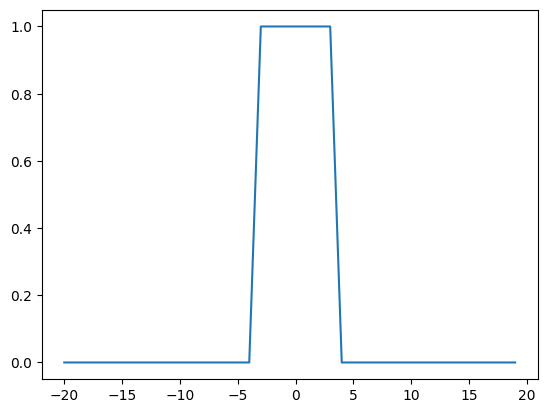

In [4]:
## 1.  Make some data
X = torch.arange(-20, 20, 1).view(-1, 1).type(torch.FloatTensor)
Y = torch.zeros(X.shape[0])
Y[(X[:, 0] > -4) & (X[:, 0] < 4)] = 1.0
plt.plot(X,Y)

In [11]:
## 2. Create a model object
# Define model class 

class Net(nn.Module):
    
    # Constructor
    def __init__(self, D_in, H, D_out):
        super(Net, self).__init__()
        # hidden layer 
        self.linear1 = nn.Linear(D_in, H)
        self.linear2 = nn.Linear(H, D_out)
        # Define the first linear layer as an attribute, this is not good practice
        self.a1 = None
        self.l1 = None
        self.l2=None
    
    # Prediction
    def forward(self, x):
        self.l1 = self.linear1(x)
        self.a1 = sigmoid(self.l1)
        self.l2=self.linear2(self.a1)
        yhat = sigmoid(self.linear2(self.a1))
        return yhat
        
# Define model object
model = Net(1, 2, 1)

# See model parameters
print( 'Default parameters:\n ', model.state_dict())

# Change model parameters
model.state_dict()['linear1.weight'][0]=1.0
model.state_dict()['linear1.weight'][1]=1.0
model.state_dict()['linear1.bias'][0]=0.0
model.state_dict()['linear1.bias'][1]=0.0
model.state_dict()['linear2.weight'][0]=1.0
model.state_dict()['linear2.bias'][0]=0.0
model.state_dict()

# See new model parameters
print( 'New parameters: \n', model.state_dict())

Default parameters:
  OrderedDict([('linear1.weight', tensor([[-0.6295],
        [-0.2532]])), ('linear1.bias', tensor([-0.3898,  0.8640])), ('linear2.weight', tensor([[-0.4583, -0.3255]])), ('linear2.bias', tensor([-0.4940]))])
New parameters: 
 OrderedDict([('linear1.weight', tensor([[1.],
        [1.]])), ('linear1.bias', tensor([0., 0.])), ('linear2.weight', tensor([[1., 1.]])), ('linear2.bias', tensor([0.]))])


In [13]:
## 3.  Define the training function

def train(Y, X, model, optimizer, criterion, epochs=1000):
    cost = []
    total=0
    for epoch in range(epochs):
        total=0
        for y, x in zip(Y, X):
            yhat = model(x)
            loss = criterion(yhat, y)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            #cumulative loss 
            total+=loss.item() 
        cost.append(total)
        if epoch % 300 == 0:    
            PlotStuff(X, Y, model, epoch, leg=True)
            plt.show()
            model(X)
            plt.scatter(model.a1.detach().numpy()[:, 0], model.a1.detach().numpy()[:, 1], c=Y.numpy().reshape(-1))
            plt.title('activations')
            plt.show()
    return cost

In [14]:
## 4. Define objects for training

# Criterion
def criterion_cross(outputs, labels):
    out = -1 * torch.mean(labels * torch.log(outputs) + (1 - labels) * torch.log(1 - outputs))
    return out
    
# Optimizer
optimizer = torch.optim.SGD(model.parameters(), lr = 0.1)

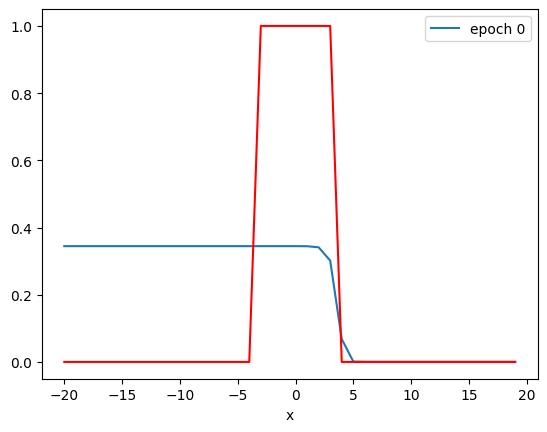

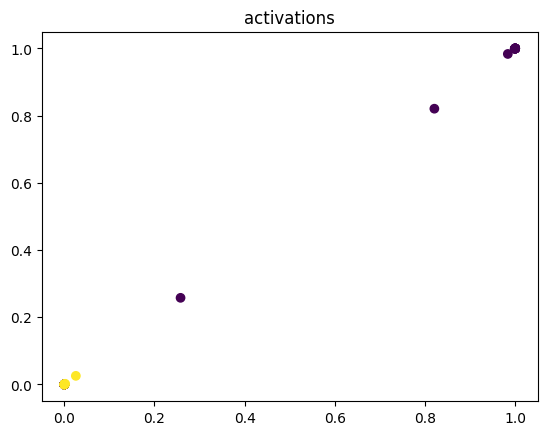

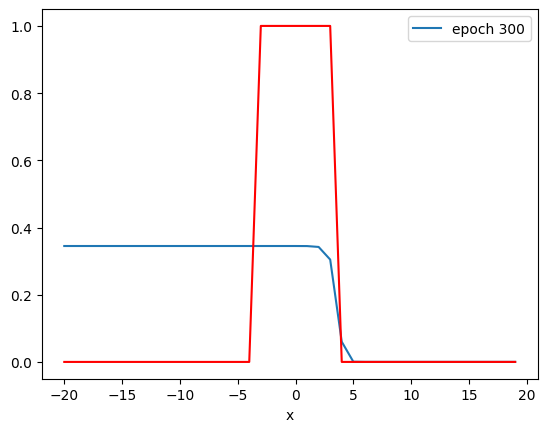

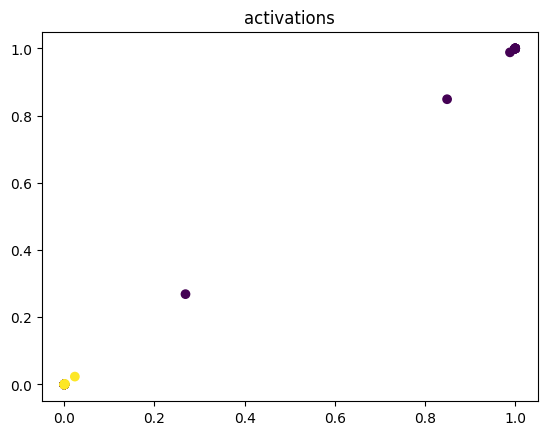

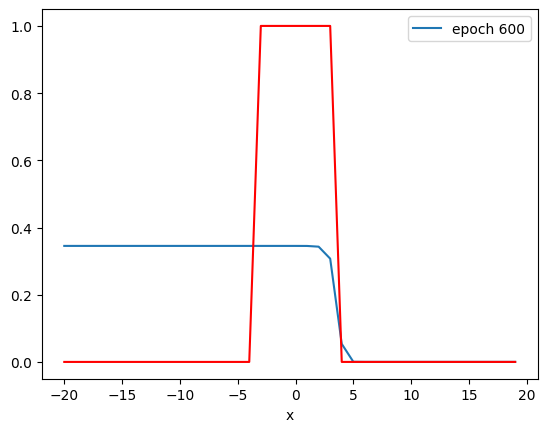

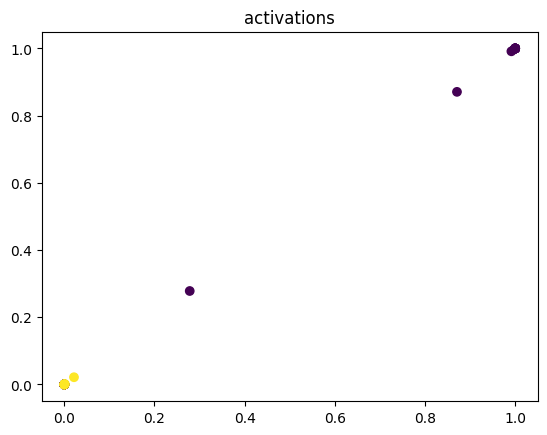

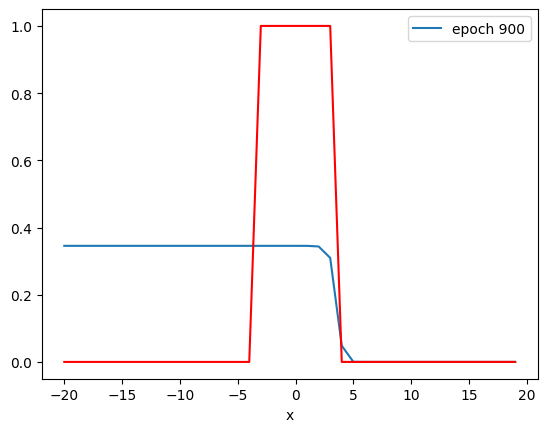

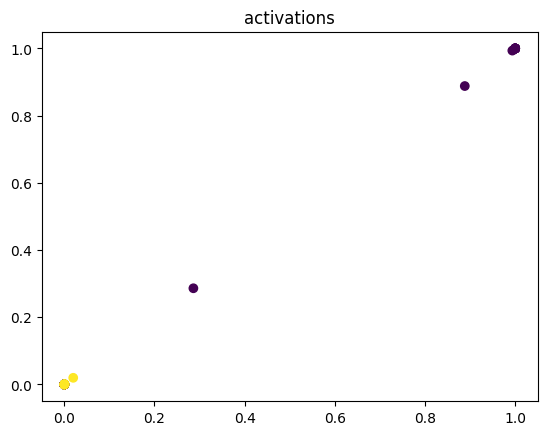

Parameters after training:
  OrderedDict([('linear1.weight', tensor([[3.0246],
        [3.0246]])), ('linear1.bias', tensor([-12.9997, -12.9997])), ('linear2.weight', tensor([[-4.1132, -4.1132]])), ('linear2.bias', tensor([-0.6385]))])


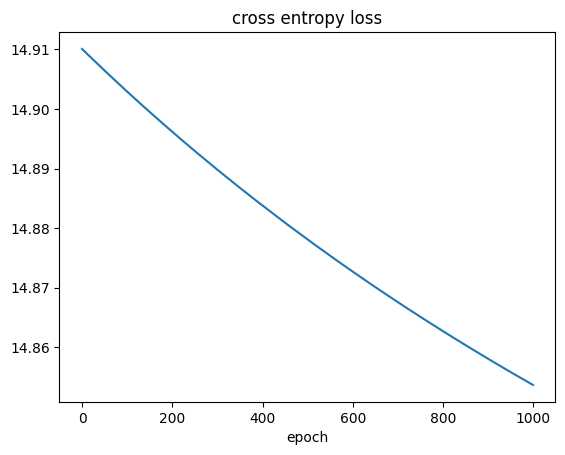

In [20]:
## 5. Train model

# Train model
cost_cross = train(Y, X, model, optimizer, criterion_cross, epochs = 1000)


# Plot the loss
plt.plot(cost_cross)
plt.xlabel('epoch')
plt.title('cross entropy loss')

# See new parameters
print('Parameters after training:\n ', model.state_dict())

We'll compare the following inicializations:
* Uniform distribution
* Default method
* Xavier method

In [21]:
## 0. Import required tools
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch import nn, optim, sigmoid
from torch.utils.data import Dataset, DataLoader

In [22]:
## 1. Import some data

# Create the train dataset
train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
# Create the validation dataset
validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

In [23]:
## 2.1 Create a model class

# Neural network class with Xavier initialization
class Net_Xavier(nn.Module):
    
    # Constructor
    def __init__(self, Layers):
        super(Net_Xavier, self).__init__()
        self.hidden = nn.ModuleList()

        for input_size, output_size in zip(Layers, Layers[1:]):
            linear = nn.Linear(input_size, output_size)
            torch.nn.init.xavier_uniform_(linear.weight)
            self.hidden.append(linear)
    
    # Prediction
    def forward(self, x):
        L = len(self.hidden)
        for (l, linear_transform) in zip(range(L), self.hidden):
            if l < L - 1:
                x = torch.tanh(linear_transform(x))
            else:
                x = linear_transform(x)
        return x

In [24]:
# 2.2 Create a model class

# Neural network class with uniform initialization
class Net_Uniform(nn.Module):
    
    # Constructor
    def __init__(self, Layers):
        super(Net_Uniform, self).__init__()
        self.hidden = nn.ModuleList()

        for input_size, output_size in zip(Layers, Layers[1:]):
            linear = nn.Linear(input_size, output_size)
            linear.weight.data.uniform_(0, 1)
            self.hidden.append(linear)
    
    # Prediction
    def forward(self, x):
        L = len(self.hidden)
        for (l, linear_transform) in zip(range(L), self.hidden):
            if l < L - 1:
                x = torch.tanh(linear_transform(x))
            else:
                x = linear_transform(x)
        return x

In [25]:
## 2.3 Create a model class

# Neural network with default initialization

class Net(nn.Module):
    
    # Constructor
    def __init__(self, Layers):
        super(Net, self).__init__()
        self.hidden = nn.ModuleList()

        for input_size, output_size in zip(Layers, Layers[1:]):
            linear = nn.Linear(input_size, output_size)
            self.hidden.append(linear)
    
    # Prediction
    def forward(self, x):
        L = len(self.hidden)
        for (l, linear_transform) in zip(range(L), self.hidden):
            if l < L - 1:
                x = torch.tanh(linear_transform(x))
            else:
                x = linear_transform(x)
        return x

In [26]:
## 3. Training function
def train(model, criterion, train_loader, validation_loader, optimizer, epochs = 100):
    i = 0
    loss_accuracy = {'training_loss':[], 'validation_accuracy':[]}  
    
    for epoch in range(epochs):
        for i,(x, y) in enumerate(train_loader):
            optimizer.zero_grad()
            z = model(x.view(-1, 28 * 28))
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            loss_accuracy['training_loss'].append(loss.data.item())
            
        correct = 0
        for x, y in validation_loader:
            yhat = model(x.view(-1, 28 * 28))
            _, label = torch.max(yhat, 1)
            correct += (label==y).sum().item()
        accuracy = 100 * (correct / len(validation_dataset))
        loss_accuracy['validation_accuracy'].append(accuracy)
        
    return loss_accuracy

In [30]:
## 4. Training objects

# Criterion
criterion = nn.CrossEntropyLoss()

# Dataloader for both train dataset and validation dataset
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=2000, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000, shuffle=False)

# Model parameters and epochs
input_dim = 28 * 28
output_dim = 10
layers = [input_dim, 100, 10, 100, 10, 100, output_dim]

# Optimizer parameters
learning_rate = 0.01
epochs = 15

In [31]:
## 5.1 Train the model with default initialization

model = Net(layers)
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
training_results = train(model, criterion, train_loader, validation_loader, optimizer, epochs=epochs)

In [32]:
## 5.2 Train the model with Xavier initialization

model_Xavier = Net_Xavier(layers)
optimizer = torch.optim.SGD(model_Xavier.parameters(), lr=learning_rate)
training_results_Xavier = train(model_Xavier, criterion, train_loader, validation_loader, optimizer, epochs=epochs)

In [33]:
## 5.3 Train the model with Uniform initialization

model_Uniform = Net_Uniform(layers)
optimizer = torch.optim.SGD(model_Uniform.parameters(), lr=learning_rate)
training_results_Uniform = train(model_Uniform, criterion, train_loader, validation_loader, optimizer, epochs=epochs)

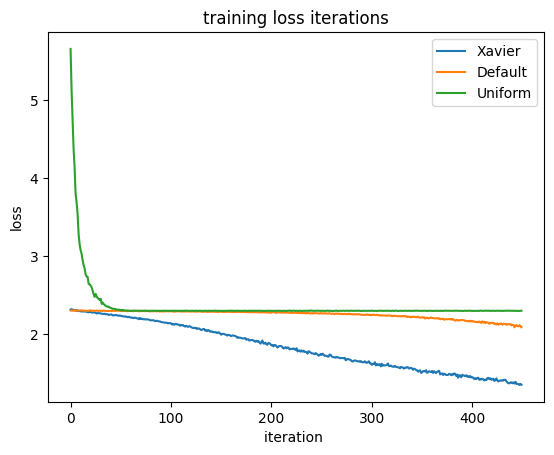

In [34]:
# Plot the loss
plt.plot(training_results_Xavier['training_loss'], label='Xavier')
plt.plot(training_results['training_loss'], label='Default')
plt.plot(training_results_Uniform['training_loss'], label='Uniform')
plt.ylabel('loss')
plt.xlabel('iteration ')  
plt.title('training loss iterations')
plt.legend()

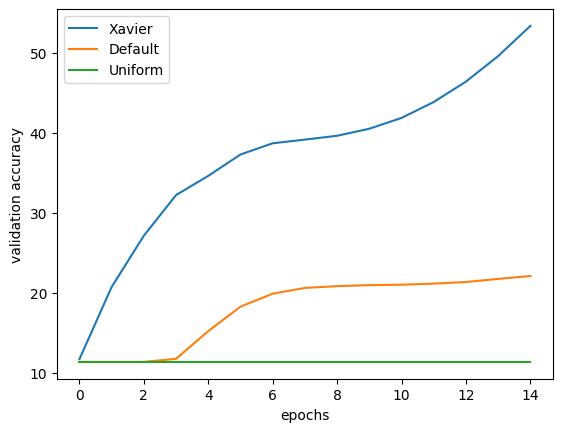

In [35]:
# Plot the accuracy
plt.plot(training_results_Xavier['validation_accuracy'], label='Xavier')
plt.plot(training_results['validation_accuracy'], label='Default')
plt.plot(training_results_Uniform['validation_accuracy'], label='Uniform') 
plt.ylabel('validation accuracy')
plt.xlabel('epochs')   
plt.legend()

We'll compare the following inicializations:
* Uniform distribution
* Default method
* Xavier method

In [36]:
## 0. Import required tools
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch import nn,optim, sigmoid
from torch.utils.data import Dataset, DataLoader

In [37]:
## 1. Import some data

# Create the train dataset
train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())
# Create the validation dataset
validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())

In [45]:
## 2.1 Create model class

# Neural netowrk class with He initialization
class Net_He(nn.Module):
    
    # Constructor
    def __init__(self, Layers):
        super(Net_He, self).__init__()
        self.hidden = nn.ModuleList()

        for input_size, output_size in zip(Layers, Layers[1:]):
            linear = nn.Linear(input_size, output_size)
            torch.nn.init.kaiming_uniform_(linear.weight, nonlinearity='relu')
            self.hidden.append(linear)

    # Prediction
    def forward(self, x):
        L = len(self.hidden)
        for (l, linear_transform) in zip(range(L), self.hidden):
            if l < L - 1:
                x = torch.relu(linear_transform(x))
            else:
                x = linear_transform(x)
        return x

In [46]:
## 2.2 Create a model class

# Neural network with uniform initialization
class Net_Uniform(nn.Module):
    
    # Constructor
    def __init__(self, Layers):
        super(Net_Uniform, self).__init__()
        self.hidden = nn.ModuleList()

        for input_size, output_size in zip(Layers, Layers[1:]):
            linear = nn.Linear(input_size,output_size)
            linear.weight.data.uniform_(0, 1)
            self.hidden.append(linear)
    
    # Prediction
    def forward(self, x):
        L = len(self.hidden)
        for (l, linear_transform) in zip(range(L), self.hidden):
            if l < L - 1:
                x = torch.relu(linear_transform(x))
            else:
                x = linear_transform(x)
                
        return x

In [47]:
## 2.3 Create a model class

# Neural network with default initilization
class Net(nn.Module):
    
    # Constructor
    def __init__(self, Layers):
        super(Net, self).__init__()
        self.hidden = nn.ModuleList()

        for input_size, output_size in zip(Layers, Layers[1:]):
            linear = nn.Linear(input_size, output_size)
            self.hidden.append(linear)
        
    def forward(self, x):
        L=len(self.hidden)
        for (l, linear_transform) in zip(range(L), self.hidden):
            if l < L - 1:
                x = torch.relu(linear_transform(x))
            else:
                x = linear_transform(x)
                
        return x

In [48]:
## 3. Training function

def train(model, criterion, train_loader, validation_loader, optimizer, epochs = 100):
    i = 0
    loss_accuracy = {'training_loss': [], 'validation_accuracy': []}  
    
    #n_epochs
    for epoch in range(epochs):
        for i, (x, y) in enumerate(train_loader):
            optimizer.zero_grad()
            z = model(x.view(-1, 28 * 28))
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            loss_accuracy['training_loss'].append(loss.data.item())
        
        correct = 0
        for x, y in validation_loader:
            yhat = model(x.view(-1, 28 * 28))
            _, label = torch.max(yhat, 1)
            correct += (label == y).sum().item()
        accuracy = 100 * (correct / len(validation_dataset))
        loss_accuracy['validation_accuracy'].append(accuracy)
    
    return loss_accuracy

In [49]:
## 4. Training objects

# Criterion 
criterion = nn.CrossEntropyLoss()

# Dataloaders
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=2000, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000, shuffle=False)

# Model parameters
input_dim = 28 * 28
output_dim = 10
layers = [input_dim, 100, 200, 100, output_dim]

# Optimizer parameters
lr = 0.01
epochs = 30

In [50]:
## 5.1 Train the model with the default initialization

model = Net(layers)
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
training_results = train(model, criterion, train_loader,validation_loader, optimizer, epochs = epochs)

In [51]:
## 5.2 Train the model with the He initialization

model_He = Net_He(layers)
optimizer = torch.optim.SGD(model_He.parameters(), lr = learning_rate)
training_results_He = train(model_He, criterion, train_loader, validation_loader, optimizer, epochs = epochs)

In [52]:
## 5.3 Train the model with the Uniform initialization

model_Uniform = Net_Uniform(layers)
optimizer = torch.optim.SGD(model_Uniform.parameters(), lr = learning_rate)
training_results_Uniform = train(model_Uniform, criterion, train_loader, validation_loader, optimizer, epochs = epochs)

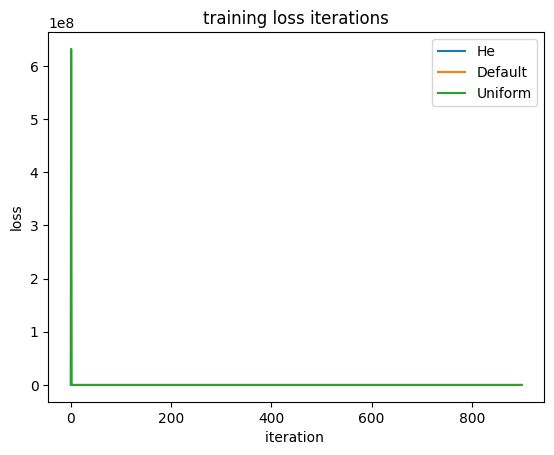

In [53]:
# Plot the loss
plt.plot(training_results_He['training_loss'], label='He')
plt.plot(training_results['training_loss'], label='Default')
plt.plot(training_results_Uniform['training_loss'], label='Uniform')
plt.ylabel('loss')
plt.xlabel('iteration ') 
plt.title('training loss iterations')
plt.legend()

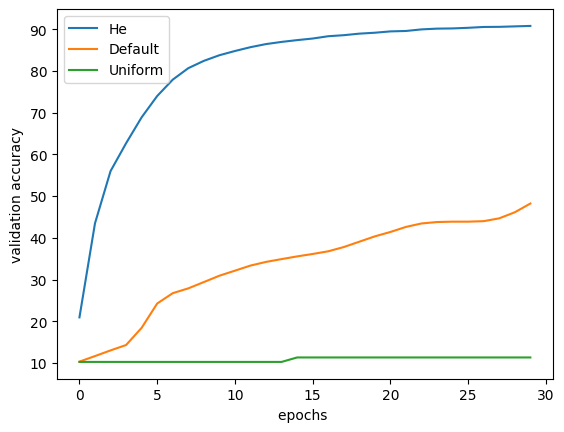

In [54]:
# Plot the accuracy
plt.plot(training_results_He['validation_accuracy'], label='He')
plt.plot(training_results['validation_accuracy'], label='Default')
plt.plot(training_results_Uniform['validation_accuracy'], label='Uniform') 
plt.ylabel('validation accuracy')
plt.xlabel('epochs ')   
plt.legend()
plt.show()

## Gradient Descent with Momentum

This method is helpfull in order to not get stuck on local minimum when executing gradient descent and go on till reaching  global minimum. 

`optimizer = torch.optim.SGD(model.parameters(), lr = 0.1, momentum = momentum)`

`momentum` is an hyperparameter. If the momentum is not too small it might not be enough to get out of the local minima, but if it's too large we might pass it. The values to try depend hardly on the nets archictecure, the dataset and the optimization method. But usally momentum values goes from 0 to 0.99.

In [16]:
## -1. Auxiliar Functions
# Define a function for plot the decision region
from matplotlib.colors import ListedColormap
def plot_decision_regions_3class(model, data_set):
    cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA','#00AAFF'])
    cmap_bold = ListedColormap(['#FF0000', '#00FF00','#00AAFF'])
    X=data_set.x.numpy()
    y=data_set.y.numpy()
    h = .02
    x_min, x_max = X[:, 0].min() - 0.1 , X[:, 0].max() + 0.1 
    y_min, y_max = X[:, 1].min() - 0.1 , X[:, 1].max() + 0.1 
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),np.arange(y_min, y_max, h))
    XX=torch.torch.Tensor(np.c_[xx.ravel(), yy.ravel()])
    _,yhat=torch.max(model(XX),1)
    yhat=yhat.numpy().reshape(xx.shape)
    plt.pcolormesh(xx, yy, yhat, cmap=cmap_light)
    plt.plot(X[y[:]==0,0], X[y[:]==0,1], 'ro', label='y=0')
    plt.plot(X[y[:]==1,0], X[y[:]==1,1], 'go', label='y=1')
    plt.plot(X[y[:]==2,0], X[y[:]==2,1], 'o', label='y=2')
    plt.title("decision region")
    plt.legend()

# Define a function for calculating accuracy
def accuracy(model, data_set):
    _, yhat = torch.max(model(data_set.x), 1)
    return (yhat == data_set.y).numpy().mean()

In [4]:
## 0. Import required tools
from torch import nn, optim, sigmoid
from torch.utils.data import Dataset, DataLoader

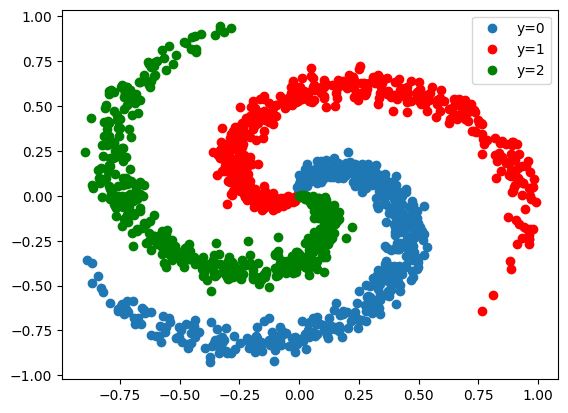

In [7]:
## 1. Create a Dateset object

# Create the dataset class
class Data(Dataset):
    
    #  modified from: http://cs231n.github.io/neural-networks-case-study/
    # Constructor
    def __init__(self, K=3, N=500):
        D = 2
        X = np.zeros((N * K, D)) # data matrix (each row = single example)
        y = np.zeros(N * K, dtype='uint8') # class labels
        for j in range(K):
          ix = range(N * j, N * (j + 1))
          r = np.linspace(0.0, 1, N) # radius
          t = np.linspace(j * 4, (j + 1) * 4, N) + np.random.randn(N) * 0.2 # theta
          X[ix] = np.c_[r * np.sin(t), r * np.cos(t)]
          y[ix] = j
    
        self.y = torch.from_numpy(y).type(torch.LongTensor)
        self.x = torch.from_numpy(X).type(torch.FloatTensor)
        self.len = y.shape[0]
            
    # Getter
    def __getitem__(self, index):    
        return self.x[index], self.y[index]
    
    # Get Length
    def __len__(self):
        return self.len
    
    # Plot the diagram
    def plot_data(self):
        plt.plot(self.x[self.y[:] == 0, 0].numpy(), self.x[self.y[:] == 0, 1].numpy(), 'o', label="y=0")
        plt.plot(self.x[self.y[:] == 1, 0].numpy(), self.x[self.y[:] == 1, 1].numpy(), 'ro', label="y=1")
        plt.plot(self.x[self.y[:] == 2, 0].numpy(),self.x[self.y[:] == 2, 1].numpy(), 'go',label="y=2")
        plt.legend()

# Create a datset object
data_set = Data()

# Plot dataset
data_set.plot_data()
data_set.y = data_set.y.view(-1)

In [12]:
## 2. Cerate model class

# Neural net with arbitrary layers and relu activaton function
class Net(nn.Module):
    
    # Constructor
    def __init__(self, Layers):
        super(Net, self).__init__()
        self.hidden = nn.ModuleList()
        for input_size, output_size in zip(Layers, Layers[1:]):
            self.hidden.append(nn.Linear(input_size, output_size))
    
    # Prediction
    def forward(self, activation):
        L = len(self.hidden)
        for (l, linear_transform) in zip(range(L), self.hidden):
            if l < L - 1:
                activation = torch.relu(linear_transform(activation))    
            else:
                activation = linear_transform(activation)
        return activation

In [9]:
## 3. Create trainer function

# Define the function for training the model
def train(data_set, model, criterion, train_loader, optimizer, epochs=100):
    LOSS = []
    ACC = []
    for epoch in range(epochs):
        for x, y in train_loader:
            optimizer.zero_grad()
            yhat = model(x)
            loss = criterion(yhat, y)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        LOSS.append(loss.item())
        ACC.append(accuracy(model,data_set))
        
    results ={"Loss":LOSS, "Accuracy":ACC}
    fig, ax1 = plt.subplots()
    color = 'tab:red'
    ax1.plot(LOSS,color=color)
    ax1.set_xlabel('epoch', color=color)
    ax1.set_ylabel('total loss', color=color)
    ax1.tick_params(axis = 'y', color=color)
    
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('accuracy', color=color)  # we already handled the x-label with ax1
    ax2.plot(ACC, color=color)
    ax2.tick_params(axis='y', color=color)
    fig.tight_layout()  # otherwise the right y-label is slightly clipped
    
    plt.show()
    return results

In [14]:
# Initialize a dictionary to contain the cost and accuracy to store for different momentum values
Results = {"momentum 0": {"Loss": 0, "Accuracy:": 0}, "momentum 0.1": {"Loss": 0, "Accuracy:": 0}}

In [10]:
## 4.1 Create training objects
train_loader = DataLoader(dataset = data_set, batch_size = 20)
criterion = nn.CrossEntropyLoss()

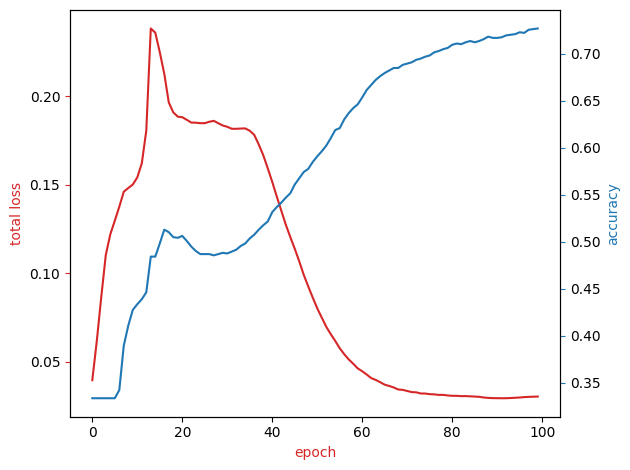

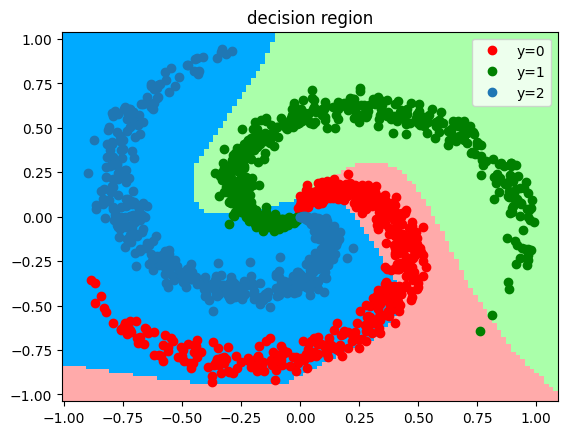

In [17]:
## 5.1 Train model

# Create model object
Layers = [2, 50, 3]
model = Net(Layers)

# Create optimizwer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1)

# Train model
Results["momentum 0"] = train(data_set, model, criterion, train_loader, optimizer, epochs=100)

# View results
plot_decision_regions_3class(model, data_set)

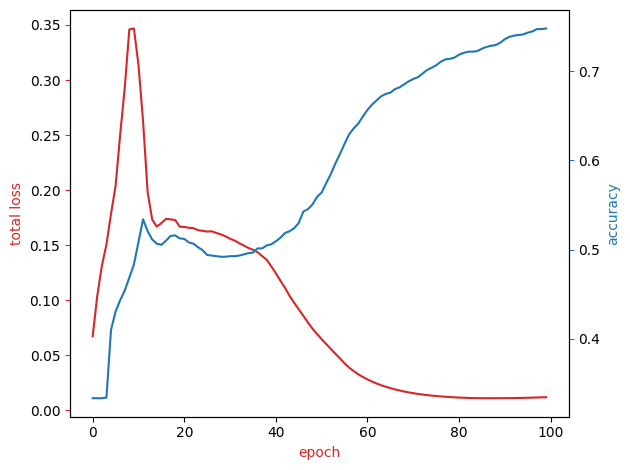

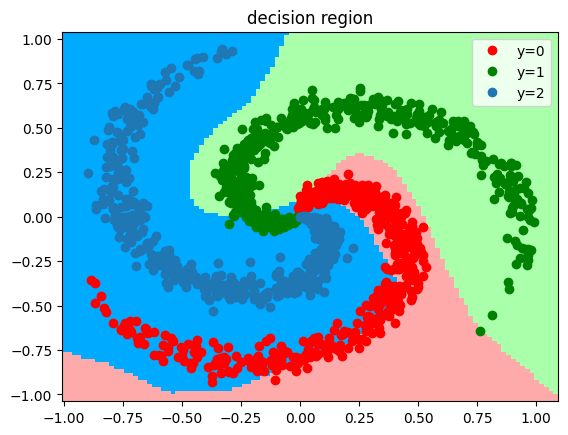

In [18]:
## 5.2 Train a model 
# 1 hidden layer 50 neurons 0.1 momentum

# Create model object
Layers = [2, 50, 3]
model = Net(Layers)

# Create optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.1)

# Train model
Results["momentum 0.1"] = train(data_set, model, criterion, train_loader, optimizer, epochs=100)

# View results
plot_decision_regions_3class(model, data_set)

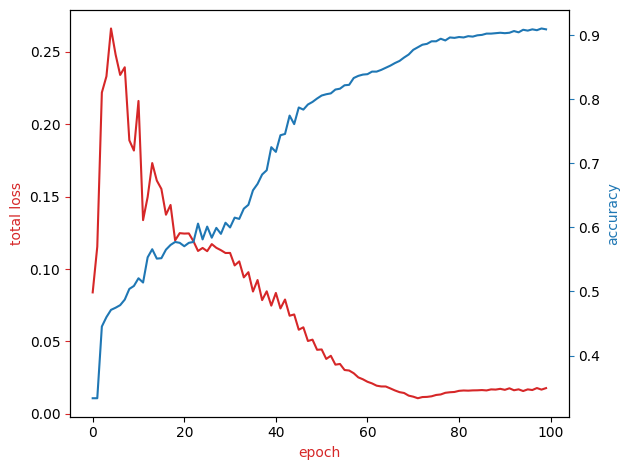

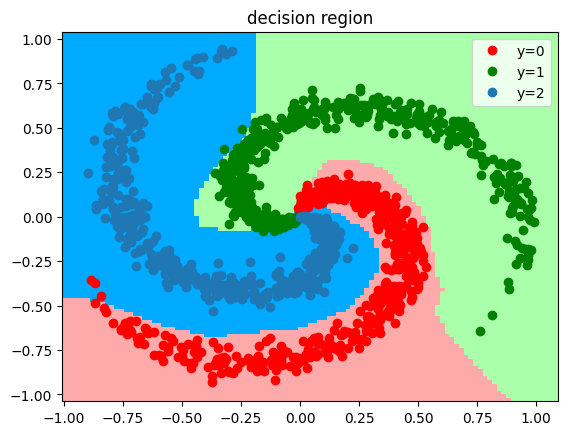

In [19]:
## 5.3 Train a model  
# 1 hidden layer  50 neurons  0.4 momentum

# Create model object
Layers = [2, 50, 3]
model = Net(Layers)

# Cerate optimizer
optimizer = torch.optim.SGD(model.parameters(), lr= 0.1, momentum=0.4)

# Train model
Results["momentum 0.4"] = train(data_set, model, criterion, train_loader, optimizer, epochs=100)

# View results
plot_decision_regions_3class(model, data_set)

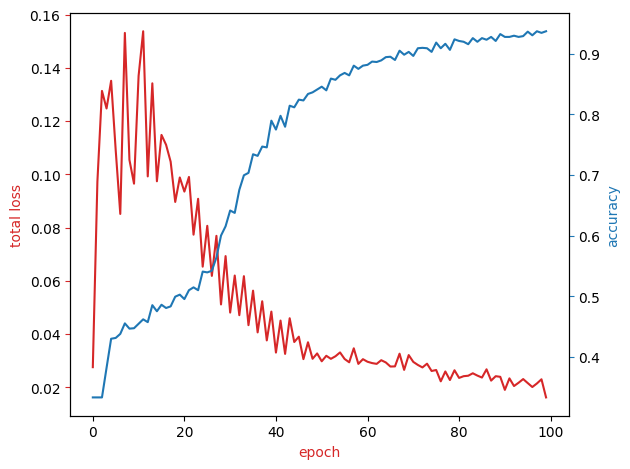

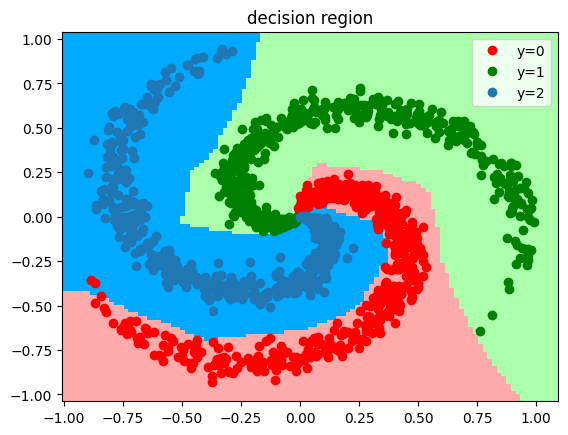

In [26]:
##  5.4 Train a model 
# 1 hidden layer  50 neurons  0.5 momentum

# Create model object
Layers = [2, 50, 3]
model = Net(Layers)

# Create optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.5)

# Train model
Results["momentum 0.5"] = train(data_set, model, criterion, train_loader, optimizer, epochs=100)

# View results
plot_decision_regions_3class(model,data_set)

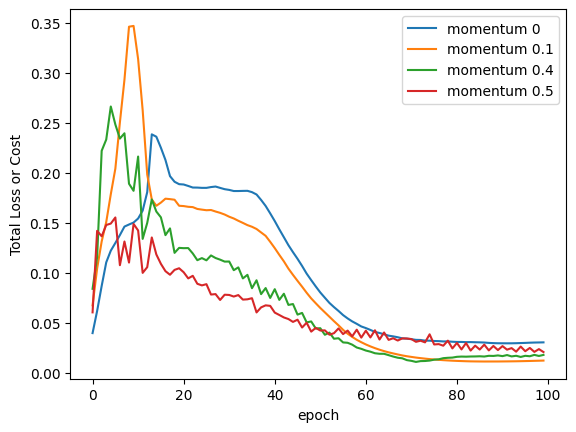

In [21]:
# Plot the Loss result for each term
for key, value in Results.items():
    plt.plot(value['Loss'],label=key)
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('Total Loss or Cost')

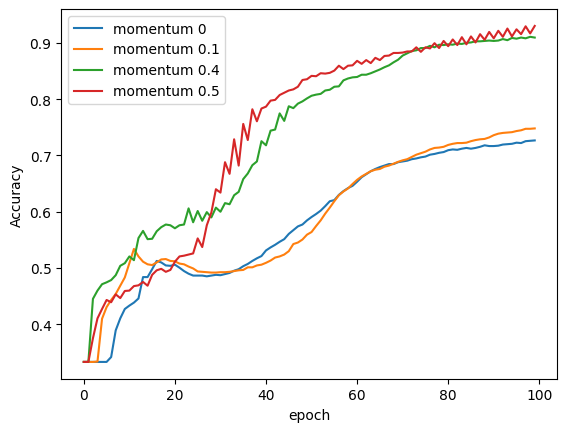

In [22]:
# Plot the Accuracy result for each term
for key, value in Results.items():
    plt.plot(value['Accuracy'],label=key)
    plt.legend()
    plt.xlabel('epoch')
    plt.ylabel('Accuracy')

## Batch normalization
Batch normalization has several benefits, including:
* Faster training: By reducing internal covariate shift, batch normalization allows for faster convergence during training. This enables the use of higher learning rates, which can accelerate training.
* Regularization: Batch normalization has a slight regularization effect due to the noise introduced by using mini-batch statistics during training.
* Stabilized gradients: Batch normalization helps to stabilize the gradients by reducing the dependence of the gradients on the scale of the parameters.
Overall, batch normalization is a widely used technique in modern neural network architectures and has contributed to significant improvements in training speed and performance. Use it in order to help the optimization algorithm to converge. 

Internal covariate shift refers to the change in the distribution of network activations due to parameter updates during training. This shift can slow down training by requiring lower learning rates and careful initialization of parameters. Batch normalization addresses this problem. The main idea behind batch normalization is to normalize the activations of each layer within a mini-batch. This normalization is performed by subtracting the mini-batch mean and dividing by the mini-batch standard deviation. Additionally, batch normalization introduces learnable parameters (scale and shift) that allow the network to adaptively scale and shift the normalized activations. During training, batch normalization computes the mini-batch statistics (mean and variance) using the activations within each mini-batch. During inference, the statistics are typically computed using the moving averages of the mini-batch statistics obtained during training.


In order to create a neural network with batch normalization and $k$ layers with l_1, ..., l_k neurons each, given an input size and an output size use the following code:
  
`class NetBatchNorm(nn.Module):`  
`    def __init__(self, layers):`  
`        super(NetBatchNorm, self).__init__()`  
`        self.hidden = nn.ModuleList()`  
`        self.batch_norm = nn.ModuleList()`  
` `  
`       for input_size, output_size in zip(layers, layers[1:]):`  
`            self.hidden.append(nn.Linear(input_size, output_size))`  
`            self.batch_norm.append(nn.BatchNorm1d(output_size))`  
` `  
`    def forward(self, activation):`  
`        L = len(self.hidden)`  
` `  
`        for l, (linear_transform, batch_norm_layer) in enumerate(zip(self.hidden, self.batch_norm)):`  
`            if l < L - 1:`  
`                activation = batch_norm_layer(linear_transform(activation))`  
`                activation = torch.relu(activation)`  
`            else:`  
`                activation = linear_transform(activation)`  
`        return activation`  
` `  
`layers = [input_dim, l_1, l_2, ..., l_k, output_size]`  
`model = NetBatchNorm(layers)`  

In [45]:
## 0. Import required tools
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch import nn, optim, sigmoid
from torch.utils.data import Dataset, DataLoader

In [46]:
## 1. Data

# Load the train dataset
train_dataset = dsets.MNIST(root='./data', train=True, download=True, transform=transforms.ToTensor())

# Load the train dataset
validation_dataset = dsets.MNIST(root='./data', train=False, download=True, transform=transforms.ToTensor())


In [47]:
## 2.1 Create a model class

# Neural Network with batch normalization
class NetBatchNorm(nn.Module):
    
    # Constructor
    def __init__(self, in_size, n_hidden1, n_hidden2, out_size):
        super(NetBatchNorm, self).__init__()
        self.linear1 = nn.Linear(in_size, n_hidden1)
        self.linear2 = nn.Linear(n_hidden1, n_hidden2)
        self.linear3 = nn.Linear(n_hidden2, out_size)
        self.bn1 = nn.BatchNorm1d(n_hidden1)
        self.bn2 = nn.BatchNorm1d(n_hidden2)
        
    # Prediction
    def forward(self, x):
        x = self.bn1(torch.sigmoid(self.linear1(x)))
        x = self.bn2(torch.sigmoid(self.linear2(x)))
        x = self.linear3(x)
        return x
    
    # Activations, to analyze results 
    def activation(self, x):
        out = []
        z1 = self.bn1(self.linear1(x))
        out.append(z1.detach().numpy().reshape(-1))
        a1 = torch.sigmoid(z1)
        out.append(a1.detach().numpy().reshape(-1).reshape(-1))
        z2 = self.bn2(self.linear2(a1))
        out.append(z2.detach().numpy().reshape(-1))
        a2 = torch.sigmoid(z2)
        out.append(a2.detach().numpy().reshape(-1))
        return out

In [48]:
## 2.2 Create a model class

# Neural Network without batch normalization
class Net(nn.Module):
    
    # Constructor
    def __init__(self, in_size, n_hidden1, n_hidden2, out_size):

        super(Net, self).__init__()
        self.linear1 = nn.Linear(in_size, n_hidden1)
        self.linear2 = nn.Linear(n_hidden1, n_hidden2)
        self.linear3 = nn.Linear(n_hidden2, out_size)
    
    # Prediction
    def forward(self, x):
        x = torch.sigmoid(self.linear1(x))
        x = torch.sigmoid(self.linear2(x))
        x = self.linear3(x)
        return x
    
    # Activations, to analyze results 
    def activation(self, x):
        out = []
        z1 = self.linear1(x)
        out.append(z1.detach().numpy().reshape(-1))
        a1 = torch.sigmoid(z1)
        out.append(a1.detach().numpy().reshape(-1).reshape(-1))
        z2 = self.linear2(a1)
        out.append(z2.detach().numpy().reshape(-1))
        a2 = torch.sigmoid(z2)
        out.append(a2.detach().numpy().reshape(-1))
        return out 


In [49]:
## 3. Training function
# Define the function to train model

def train(model, criterion, train_loader, validation_loader, optimizer, epochs=100):
    i = 0
    useful_stuff = {'training_loss':[], 'validation_accuracy':[]}  

    for epoch in range(epochs):
        for i, (x, y) in enumerate(train_loader):
            model.train()
            optimizer.zero_grad()
            z = model(x.view(-1, 28 * 28))
            loss = criterion(z, y)
            loss.backward()
            optimizer.step()
            useful_stuff['training_loss'].append(loss.data.item())
            
        correct = 0
        for x, y in validation_loader:
            model.eval()
            yhat = model(x.view(-1, 28 * 28))
            _, label = torch.max(yhat, 1)
            correct += (label == y).sum().item()
            
        accuracy = 100 * (correct / len(validation_dataset))
        useful_stuff['validation_accuracy'].append(accuracy)
    
    return useful_stuff

In [50]:
## 4. Training objects

# Create criterion
criterion = nn.CrossEntropyLoss()

# Create Data Loader for both train and validating
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=2000, shuffle=True)
validation_loader = torch.utils.data.DataLoader(dataset=validation_dataset, batch_size=5000, shuffle=False)

In [51]:
## 5.1 Train with batch nomalization 

# Create model object
input_dim = 28 * 28
hidden_dim = 100
output_dim = 10
model_norm  = NetBatchNorm(input_dim, hidden_dim, hidden_dim, output_dim)

# Create optimizar
optimizer = torch.optim.Adam(model_norm.parameters(), lr = 0.1)

# Train model
training_results_Norm=train(model_norm , criterion, train_loader, validation_loader, optimizer, epochs=5)


In [52]:
## 5.2 Train without  batch nomalization 

# Create model object
input_dim = 28 * 28
hidden_dim = 100
output_dim = 10
model = Net(input_dim, hidden_dim, hidden_dim, output_dim)

# Create optimizer
optimizer = torch.optim.Adam(model.parameters(), lr = 0.1)

# Train model
training_results = train(model, criterion, train_loader, validation_loader, optimizer, epochs=5)

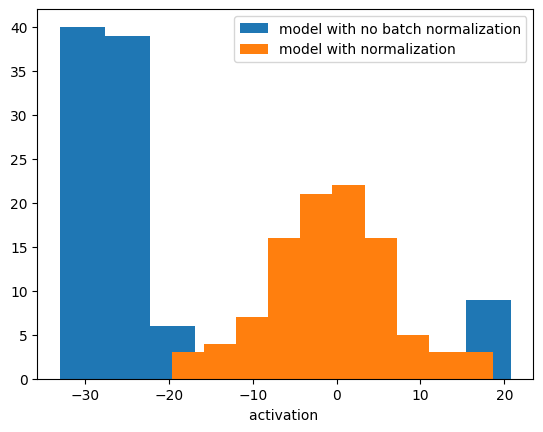

In [53]:
# Compare the histograms of the activation for the first layer of the first sample, for both models.
model.eval()
model_norm.eval()
out=model.activation(validation_dataset[0][0].reshape(-1,28*28))
plt.hist(out[2],label='model with no batch normalization' )
out_norm=model_norm.activation(validation_dataset[0][0].reshape(-1,28*28))
plt.hist(out_norm[2],label='model with normalization')
plt.xlabel("activation ")
plt.legend()
plt.show()

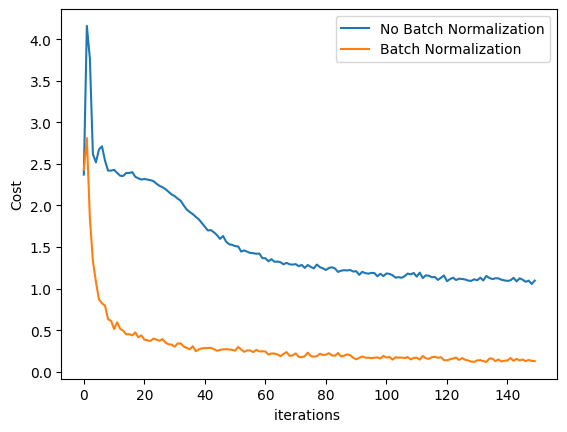

In [54]:
# Plot the diagram to show the loss

plt.plot(training_results['training_loss'], label='No Batch Normalization')
plt.plot(training_results_Norm['training_loss'], label='Batch Normalization')
plt.ylabel('Cost')
plt.xlabel('iterations ')   
plt.legend()
plt.show()

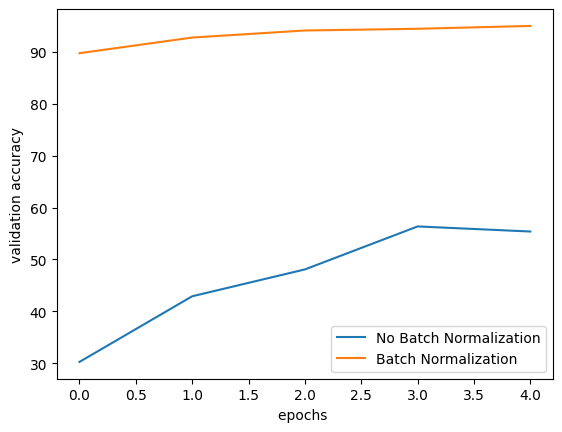

In [55]:
# Plot the diagram to show the accuracy

plt.plot(training_results['validation_accuracy'],label='No Batch Normalization')
plt.plot(training_results_Norm['validation_accuracy'],label='Batch Normalization')
plt.ylabel('validation accuracy')
plt.xlabel('epochs ')   
plt.legend()
plt.show()

In [4]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y
